<a href="https://colab.research.google.com/github/brendanhasz/tfp-bayesian-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Regressions via MCMC or Variational Methods using TensorFlow Probability

One way to fit Bayesian models is using Markov chain Monte Carlo (MCMC) sampling. These methods generate samples from the posterior distribution such that the number of samples generated in a region of parameter-space is proportional to the posterior probability of those parameter values.  (Check out this [great animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana) by Chi Feng to see how different MCMC algorithms sample the posterior distribution.) Programs and packages like [Stan](http://mc-stan.org/), [JAGS](http://mcmc-jags.sourceforge.net/), [BUGS](http://www.openbugs.net/w/FrontPage), [Edward](http://edwardlib.org/), and [PyMC3](https://docs.pymc.io/) implement MCMC sampling from user-specified Bayesian models.

One downside of these packages (with the exception of Edward) is that they don't support parallel or distributed sampling.  You can run independent sampling chains in parallel, of course, but any single chain with any of these environments is single-threaded.  This becomes a problem when you've got lots of data, because your models take forever to fit!  With many models, the computation of the posterior probability (and its gradient) can be distributed, and so computing these in a distributed way would significantly speed up sampling.

Most MCMC methods, like [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) (HMC), and the [No-U-Turn sampler](http://www.jmlr.org/papers/v15/hoffman14a.html) (NUTS), use the gradient of the posterior probability to traverse parameter-space in order to efficiently sample the posterior.  Stan (and other packages) use [reverse-mode automatic differentiation](https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation) to compute the gradient (also see [this post](https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation)).  Basically this allows the user to build a program to compute the posterior probability from a model and data, and the gradient of the posterior is computed from this program automatically using the derivatives of simple components of that program and the chain rule.

It occurred to me that this is exaclty what [TensorFlow](https://www.tensorflow.org/) does!  Edward (which runs on top of TensorFlow) implements a few types of MCMC samplers, but not the NUTS sampler.  While googling for a TensorFlow-based NUTS sampler, I stumbled across [TensorFlow Probability](https://www.tensorflow.org/probability/), which is a new offshoot of TensorFlow, dedicated to fitting probabilistic modeling.  And they're working on a NUTS sampler for it!

In this post we'll use TensorFlow Probability to build and fit Bayesian Regression models, first with MCMC and then using stochastic variational inference.

>[Bayesian Regressions via MCMC or Variational Methods using TensorFlow Probability](#scrollTo=nwfwD2lsgp64)

>>[Data](#scrollTo=5Sl3oQAlVVYQ)

>>[Markov Chain Monte Carlo](#scrollTo=VeuCuk2zgPTx)

>>>[Bayesian Model](#scrollTo=9cCxquAOP-Sp)

>>>[MCMC Sampling](#scrollTo=4T_pXKJbVPs1)

>>>[Posterior](#scrollTo=3LjFseDRiyfl)

>>>[Predictive Distribution](#scrollTo=vXRshfpUd_nc)

>>[Variational Bayes](#scrollTo=AVYSmZ6exIlh)

>>>[Data Pipeline](#scrollTo=HUlFbmPpzboP)

>>>[Variational Model](#scrollTo=p1rmKI6ozuK0)

>>>[Fitting the Variational Model](#scrollTo=Pd_WGG-ziII4)

>>>[Parameters and metrics over training](#scrollTo=EVct2VF8X9d3)

>>>[Posterior](#scrollTo=LbDLJkLAtGCY)

>>>[Prediction Distributions](#scrollTo=e9ljOhywieDm)

>>[Comparing MCMC and Variational Fits](#scrollTo=q0VU7eLaagiu)

>>>[Posteriors](#scrollTo=E-aZrH4ni1TK)

>>>[Prediction Distributions](#scrollTo=TL8RbElNitoo)

>>[Conclusion](#scrollTo=2_LECAWfpeTm)



First let's load the packages we need.  

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

We need some data to fit our Bayesian models to!  Let's use a simple linear model to generate some data:

\begin{align*}
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}

where 

* $y_i$ is the observed value for datapoint $i$,
* $\alpha$ is a bias parameter (the intercept),
* $x_i$ is the vector of features (independent variables) for datapoint $i$,
* $\beta$ is a vector of coefficients (weights), and
* $\sigma$ is the error standard deviation.

So, the $y$ value of each datapoint is set by the intercept, plus the effect of the dependent variables according to the weights, plus some noise.

In [0]:
# Settings
D = 4   #number of dimensions
N = 100 #number of datapoints to generate
noise_std_true = 1.0

# Generate data
b_true = np.random.randn(1).astype(np.float32)    #bias (alpha)
w_true = np.random.randn(D, 1).astype(np.float32) #weights (beta)
x = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N,1).astype(np.float32)
y = np.matmul(x, w_true) + b_true + noise

Let's view the datapoints we generated.

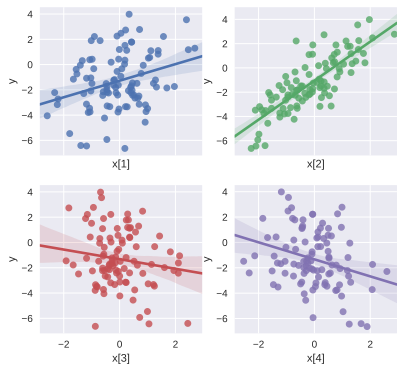

In [0]:
# Show data
fig, axes = plt.subplots(int(np.ceil(D/2)), 2, sharex=True)
fig.set_size_inches(6.4, 6)
for i in range(D):
  t_ax = axes[int(i/2), i%2] #this axis
  sns.regplot(x[:,i], y[:,0], ax=t_ax)
  t_ax.set_ylabel('y')
  t_ax.set_xlabel('x[%d]'%(i+1))
plt.show()

The bias looks to be around $2$, and some weights look likely positive (like $\beta_2$), while other weights look likely to be negative (like $\beta_3$ and $\beta_4$).  Let's take a look at the parameters which were used to generate the data.

In [0]:
print('True bias: %0.2f' % b_true)
print('True weights: ', w_true[:,0])

True bias: -1.13
True weights:  [ 0.3843192  1.4965538 -0.3553823 -0.7875335]


## Markov Chain Monte Carlo

The first method for fiting Bayesian models we'll look at is Markov chain Monte Carlo (MCMC) sampling.  Again, MCMC methods traverse parameter-space, generating samples from the posterior distribution such that the number of samples generated in a region of parameter-space is proportional to the posterior probability in that region of parameter-space.

### Bayesian Model

The model we'll use is a simple Bayesian linear regression.  That is, the same model we used to generate the data:

\begin{align*}
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}

However, we'll also put priors on the parameters:

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
\alpha &\sim \text{Normal}(0, 1) \\
\end{align*}

We'll use the `edward` module from TensorFlow Probability to code the model:

In [0]:
def linear_regression(features):
  D = features.shape[1]      #number of dimensions
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions

We want to perform MCMC within the joint probability distribution of all the parameters, so we'll have to convert our function above into a joint distribution function (`edward` provides a function to do that).  

In [0]:
# Joint posterior distribution
log_joint = ed.make_log_joint_fn(linear_regression)

We'll also need a function to compute the log posterior probability

In [0]:
# Function to compute the log posterior probability
def target_log_prob_fn(coeffs, bias, noise_std):
  return log_joint(
      features=x,
      coeffs=coeffs,
      bias=bias,
      noise_std=noise_std,
      predictions=y)

### MCMC Sampling

Now that we've built the model, we can use MCMC sampling to estimate the posterior distribution.  

First though, let's make a timer,

In [0]:
class Timer:
  def __enter__(self):
    self.t0 = time.time()
  def __exit__(self, *args):
    print('Elapsed time: %0.2fs' % (time.time()-self.t0))

so that now we can time blocks of code inside `with Timer()`:

In [0]:
with Timer():
  time.sleep(3.14)

Elapsed time: 3.14s


Before sampling, we need to set how many sampling iterations we want to perform, and the number of burn-in steps (we toss samples up to the number of burn-in steps).  We also need to set the HMC step size and the number of leapfrog steps (the number of steps to take after an initial momentum is applied before a "sample" is taken).

In [0]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps
step_size = 0.01
num_leapfrog_steps = 10

# Parameter sizes
coeffs_size = [D,1]
bias_size = [1]
noise_std_size = [1]

Then, we can define the transition kernel we'll use (Hamiltonian Monte Carlo, though TFP offers a [bunch](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc) of different sampling algorithms, including an [experimental NUTS sampler](https://github.com/tensorflow/probability/tree/master/experimental/no_u_turn_sampler)).  We'll also create a TensorFlow graph to generate the entire chain of samples. 

In [0]:
# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])
coeffs, bias, noise_std = states

Finally, we can run the MCMC sampling chain, and afterwards remove samples during the burn-in period.

In [0]:
# Run the chain
with Timer(), tf.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      bias,
      noise_std,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = bias_[n_burnin:]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

Elapsed time: 20.36s


One thing we have to check for is that not *all* our sampling iterations have been rejected (that is, that many are accepted).  Hamiltonian Monte Carlo only accepts a sample when the posterior probability at the proposed sample location is favorable compared to the probability at the previous location.  If none of our samples are being accepted, it could mean that the step size is too large, or larger problems with the model.

In [0]:
print('Acceptance rate: %0.1f%%' % (100*np.mean(accepted_samples)))

Acceptance rate: 99.8%


There's quite a few other MCMC diagnostics which one would usually want to check for, including chain convergence, energy Bayesian fraction of missing information (E-BFMI), divergences, etc, which I talked about in a [previous post](https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html).  Unfortunately, TFP doesn't yet provide functions to check these.  Though, checking for chain convergence could be done manually pretty easily.

### Posterior

Next, we'll take a look at the posterior distributions for the parameters of our model.  In each of the plots below, the solid vertical line is the true value of the parameter, the distribution is the posterior as estimated by MCMC sampling, and the dotted lines indicate the 95% confidence interval of the posterior distribution.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

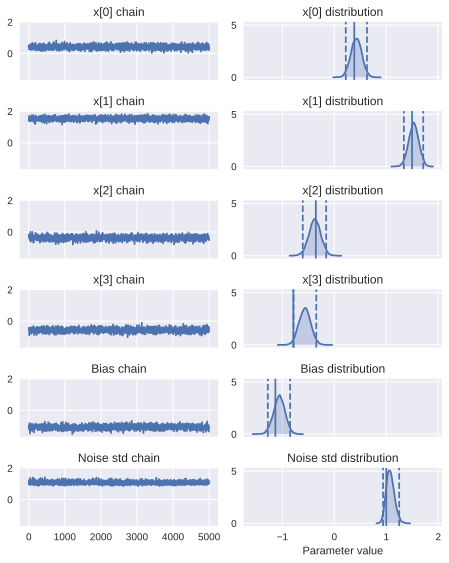

In [0]:
def chain_plot(data, title='', ax=None):
  '''Plot both chain and posterior distribution'''
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  '''Plot a chain of MCMC samples'''
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 2, sharex='col', sharey='col')
fig.set_size_inches(6.4, 8)
for i in range(D):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=w_true[i])
  
# Plot chains and distributions for bias
chain_post_plot(bias_samples[:,0],
                title="Bias",
                ax=axes[D], true=b_true)

# Plot chains and distributions for noise std dev
chain_post_plot(noise_std_samples[:,0],
                title="Noise std",
                ax=axes[D+1], true=noise_std_true)
  
axes[D+1][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

It looks like our model accurately recovered the true parameters used to generate the data!

### Predictive Distribution

To "criticize" our model, we can take a look at the posterior predictive distributions on held-out (validation) data.  The posterior predictive distribution is the distribution of $y$ values which our model predicts for a given held-out $x$, if we assume that the true parameter values follow the probability distribution that we computed using the non-held-out data (the posterior).  That is, it's how likely any given $y$ value is for a new $x$ value, if we incorporate all our sources of uncertainty.

To look at the posterior predictive distributions, we need held-out data, so we'll first generate some validation data:

In [0]:
# Generate held out data
N_val = 1000
x_val = np.random.randn(N_val, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N_val, 1).astype(np.float32)
y_val = np.matmul(x_val, w_true) + b_true + noise

Then we can compute the predictive distributions.  We'll draw one sample from our probabilistic model per MCMC sample from the posterior distribution (though we could do more).

TensorFlow Probability (and Edward) provide a method to do this they call "intercepting", which allows the user to set the value of the model parameters, and then draw a sample from the model.  Unfortunately this method isn't well-suited to drawing many samples each with different parameter values (i.e. it takes a long time), so we'll just do it manually.

In the figure below, each plot corresponds to a different validation datapoint (I've only plotted 8 out of the 1000 we generated), the vertical lines show the true value of $y$ for that datapoint, and the distributions show the predictive distristribution (our guess for how likely each value of $y$ is given our model and our uncertainty as to the model's parameters).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

Text(0.5,0,'y')

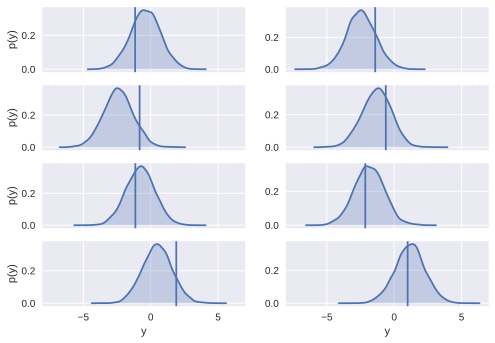

In [0]:
def ind_prediction_distribution(X):
  '''Compute the prediction distribution for an individual validation example'''
  predictions = np.matmul(X, coeffs_samples.transpose()) + bias_samples[:,0]
  noise = noise_std_samples[:,0]*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Compute prediction distribution for all validation samples
Nmcmc = coeffs_samples.shape[0]
prediction_distribution = np.zeros((N_val, Nmcmc))
for i in range(N_val):
  prediction_distribution[i,:] = ind_prediction_distribution(x_val[i,:])

# Plot random datapoints and their prediction intervals
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
  axes[i][0].set_ylabel('p(y)')
  
axes[3][0].set_xlabel('y')
axes[3][1].set_xlabel('y')

We can also take the mean of each posterior predictive distribution, and compute the residuals (difference between the mean of each held-out datapoint's true $y$ value and the mean of that datapoint's posterior predictive distribution).

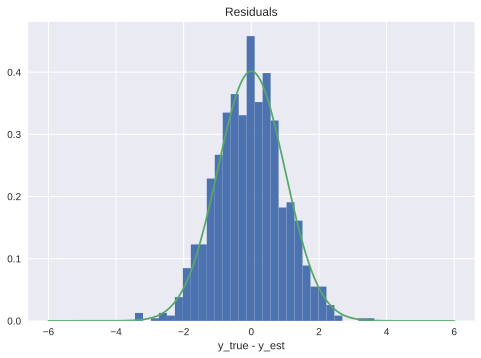

In [0]:
# Plot the residual distribution
plt.figure()
y_pred = np.mean(prediction_distribution, axis=1)
residuals = y_val[:,0]-y_pred
plt.hist(residuals, bins=30, density=True)
xx = np.linspace(-6, 6, 200)
plt.plot(xx, norm.pdf(xx, scale=np.std(residuals)))
plt.title('Residuals')
plt.xlabel('y_true - y_est')
plt.show()

We used a normal distribution to model the error, so the residuals should be normally-distributed.  The residuals look pretty good normally-distributed, but if they hadn't, we might have wanted to change the type of distribution used to model noise.

To asses how accurate our uncertainty estimates are, we can compute the coverage of the 95% interval.  That is, how often does the true $y$ value actually fall within the 95% interval of our posterior predictive distribution?  If our model is accurately capturing its uncertainty, then 95% of the true values should fall within the 95% interval of their posterior predictive distributions.

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_distribution[i,:]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

97.4 % of validation samples are w/i the 95.0 % prediction interval


The true coverage of the 95% interval is close to 95%, which means our model is pretty well-calibrated!

## Variational Bayes

Despite its ability to accurately capture uncertainty, one big problem with MCMC sampling is that it's slow.  It took around 20s to sample from the posterior of our simple model with only 100 datapoints!  That might not sound too bad, but speed becomes huge when trying to fit models to real (i.e. large) datasets, especially when the model is more complex.

To speed things up while still capturing uncertainty, we can make some simplifying assumptions and use [stochastic variational inference](http://www.jmlr.org/papers/v14/hoffman13a.html).  These assumptions are that our model's parameters are completely independent of each other (which MCMC sampling does not assume, since it samples from the joint distribution), and that the posterior for each of our parameters is normally distributed.  

How do these assumptions change how we can infer the model parameters?  Instead of sampling from the posterior a bunch of times like we did with MCMC (which takes too long), and instead of simply optimizing the parameters (which only gets us a single best point estimate and no uncertainty information), we'll compromise.  We'll use stochastic gradient descent to optimize the parameters, but instead of just optimizing the parameter values, we'll replace each single parameter value with a normal distribution.  This doubles the numbers of parameters in the model, because now we have a mean parameter and a variance parameter for each single parameter we had before.  At each training step, we'll sample a value from that normal distribution to get the value of the parameter for that training step.  Then we can update all the mean and variance parameters (for each original parameter) through backpropogation, instead of updating the point value of the parameter.  We'll also have to use the evidence lower bound (ELBO) loss function.

The advantage of stochastic variational inference over simply optimizing the parameters' values is that we capture uncertainty as to the model parameter values (because we're treating each parameter as a normal distribution now, which has some variance).  An added bonus is that stochastically sampling from the variational distributions regularizes our model, helping to prevent overfitting.  However, while it's faster than MCMC sampling, it also makes more assumptions than MCMC sampling does (about the shape of the individual parameters' posteriors and their independence).

We'll use a super-simple Bayesian neural network with no activation (which is equivalent to the model we fit with MCMC earlier) and see if it captures the same level of uncertainty as the previous model which we fit with MCMC.

First we'll set the batch size, number of training iterations, and the learning rate.

In [0]:
# Settings
batch_size = 50
max_steps = 2000
learning_rate = 0.005

### Data Pipeline

For the variational model, we first need to set up a data pipeline which can feed data to our model in batches, and can switch between feeding the training data and the validation data. 

In [0]:
# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

In [0]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


### Variational Model

Now we can construct the variational model.  It will have a single "dense" layer, with one output unit which has no activation function.  This is just multiplying the inputs by the weights, and adding them together - plus an intercept - with normally-distributed noise. This is the same thing our model did which we fit using MCMC. 

Tensorflow probability provides functions to generate neural network layers where the parameters are inferred via variational inference.  The "flipout" layer randomly samples parameter values from their variational distributions in an efficient way.

However, we also need to infer the value of the noise standard deviation parameter variationally, so we'll do that one manually.  To do that, we'll first need a function to generate a variational distribution.

In [0]:
def VariationalParameter(name, shape, constraint=None):
  """Generates variational distribution(s)"""
  means = tf.get_variable(name+'_mean', 
                          initializer=tf.ones([1]),
                          constraint=constraint)
  stds = tf.get_variable(name+'_std', 
                         initializer=-2.3*tf.ones([1]))
  return tfd.Normal(loc=means, scale=tf.math.exp(stds))

Then we can construct the variational model using a flipout layer (with no activation) and our variationally-inferred noise standard deviation parameter.

In [0]:
# A linear regression model: a Normal distribution
# parameterized by location from a single linear layer.
with tf.name_scope("linear_regression", values=[x_vals]):
  layer = tfp.layers.DenseFlipout(
      units=1, 
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
  predictions = layer(x_vals)  
  noise_std = VariationalParameter('noise_std', [1],
                                   constraint=tf.keras.constraints.NonNeg())
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=noise_std.sample())

### Fitting the Variational Model

Before fitting the model, we have to define the ELBO loss, and an error metric for evaluation (we'll use mean squared error), and which optimizer to use (we'll use Adam).

In [0]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N
elbo_loss = neg_log_likelihood + kl_div

# Mean squared error metric for evaluation
mse, mse_update_op = tf.metrics.mean_squared_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

Then we can run the training iterations, while storing the values of our parameters over training.  The second-to-last code block below samples the parameters' posterior distributions at the end of training, and the last code block samples the model given held out data (which gives us the predictive distributions).

In [0]:
# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
noise_std_mean = noise_std.mean()
noise_std_std = noise_std.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
noise_means = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_means[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std_mean,
          noise_std_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  n_draw = noise_std.sample(Nmc)
  w_post, b_post, n_post = sess.run([w_draw, b_draw, n_draw])
  
  # Draw predictive distribution samples
  prediction_dist_var = sess.run((pred_distribution.sample(Nmc)), 
                                 feed_dict={handle: val_handle})

Elapsed time: 2.68s


Notice that this was a lot faster than MCMC sampling!  (20s for MCMC, ~2.5s for variational)

### Parameters and metrics over training

Let's visualize the means of the variational distributions (the normal distributions we replaced each parameter with) for each weight parameter over the course of training.

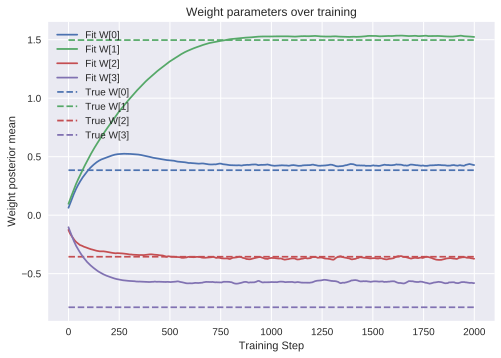

In [0]:
# Plot value of weights over training
plt.figure()
for iW in range(D):
  plt.plot(weight_means[:,iW], label='Fit W[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(w_true[iW], 0, max_steps, label='True W[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

Similarly, we can visualize the standard deviation of the variational distributions over training:

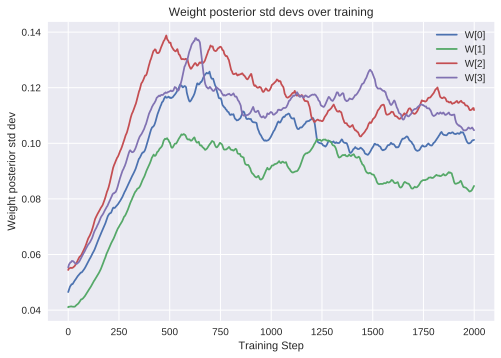

In [0]:
# Plot value of weight std devs over training
plt.figure()
for iW in range(D):
  plt.plot(weight_stds[:,iW], label='W[{}]'.format(iW), 
           color=colors[iW])
plt.xlabel('Training Step')
plt.ylabel('Weight posterior std dev')
plt.title('Weight posterior std devs over training')
plt.legend()
plt.show()

We'll also take a look at the bias and noise parameters over training, as well as the mean squared error and ELBO loss.

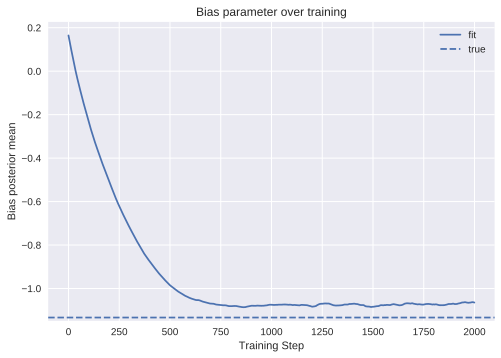

In [0]:
# Plot value of bias over training
plt.figure()
plt.plot(bias_means, label='fit')
plt.axhline(b_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior mean')
plt.title('Bias parameter over training')
plt.legend()
plt.show()

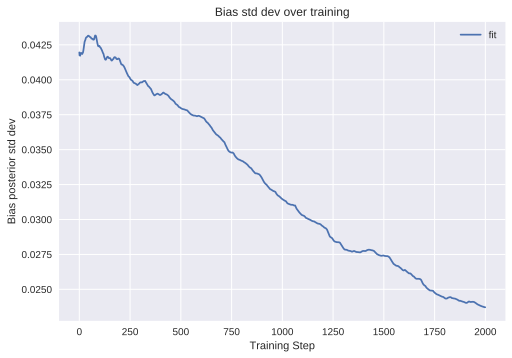

In [0]:
# Plot value of bias std dev over training
plt.figure()
plt.plot(bias_stds, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior std dev')
plt.title('Bias std dev over training')
plt.legend()
plt.show()

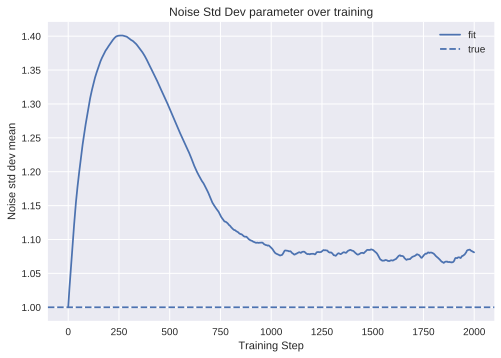

In [0]:
# Plot value of noise std dev over training
plt.figure()
#plt.plot(noise_stds, label='fit')
plt.plot(noise_means, label='fit')
plt.axhline(noise_std_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev mean')
plt.title('Noise Std Dev parameter over training')
plt.legend()
plt.show()

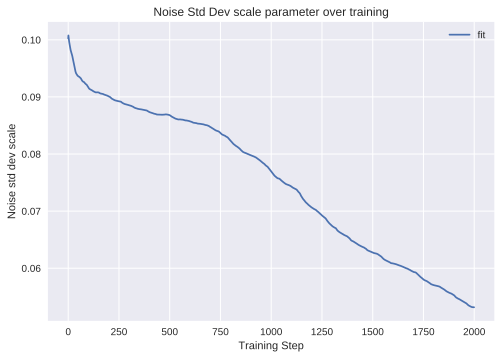

In [0]:
# Plot value of bias std dev over training
plt.figure()
plt.plot(noise_stds, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev scale')
plt.title('Noise Std Dev scale parameter over training')
plt.legend()
plt.show()

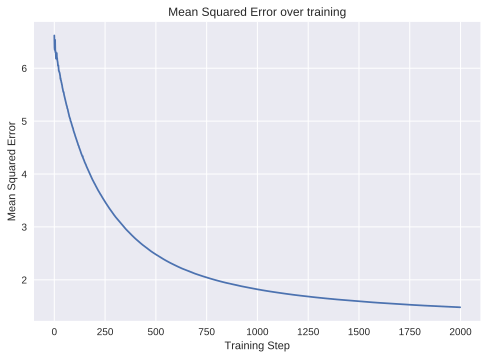

In [0]:
# Plot mean squared error over training
plt.figure()
plt.plot(mses[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over training')
plt.show()

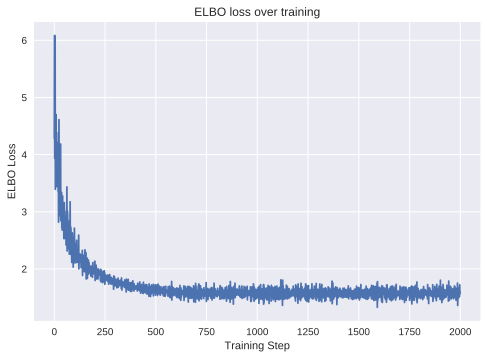

In [0]:
# Plot ELBO loss over training
plt.figure()
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('ELBO Loss')
plt.title('ELBO loss over training')
plt.show()

### Posterior

Like with MCMC sampling, we can sample from the model using the variational distributions at the end of training.  This was done above when we ran the training session (see the code block `Draw samples from the posterior`).  Now we'll plot the computed posteriors (distributions below) against the true parameter values (vertical lines).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

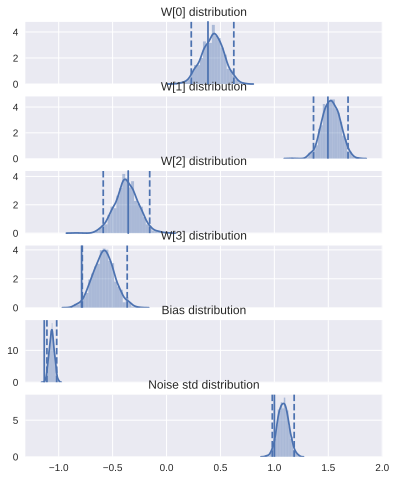

In [0]:
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.distplot(data, ax=ax)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)

# Plot weight posteriors
fig, axes = plt.subplots(D+2, 1, sharex=True)
fig.set_size_inches(6.4, 8)
for i in range(D):
  post_plot(w_post[:,i,0], title='W[{}]'.format(i), 
            ax=axes[i], true=w_true[i])
  
# Plot Bias posterior
post_plot(b_post[:,0], title='Bias', 
          ax=axes[D], true=b_true)

# Plot noise std dev posterior
post_plot(n_post[:,0], title='Noise std',
          ax=axes[D+1], true=noise_std_true)
  
plt.show()

### Predictive Distributions

Variational inference can also get us the posterior predictive distributions.  Again these were computed while running the training session above (see the code block `Draw predictive distribution samples`).  Now we can compare the posterior predictive distributions for each validation datapoint (distributions below) to the true $y$ value of that validation datapoint (vertical lines).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

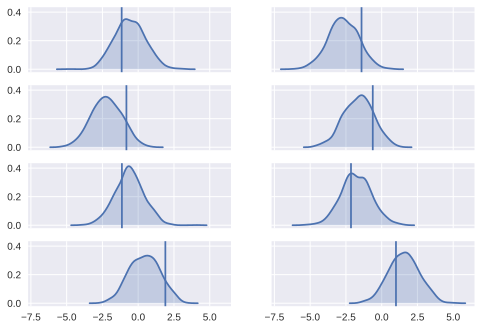

In [0]:
# Plot random datapoints and their prediction distributions
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_dist_var[:, ix, 0]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])

Using these posterior predictive distributions, we can compute the coverage of the 95% interval (how often the true $y$ value falls within our 95% confidence interval):

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

93.7 % of validation samples are w/i the 95.0 % prediction interval


## Comparing MCMC and Variational Fits

Now we can compare the fit using MCMC to the variational fit.  We'll first see how the parameter posteriors from each method stack up to each other, and then we'll compare the posterior predictive distributions from each method.

### Posteriors

The blue distributions below are the posterior distributions for each parameter as estimated by MCMC, while the green distributions are the posterior distributions as estimated by variational inference.  For the noise standard deviation parameter, this is a point estimate for the variational model, and so that estimate is a vertical line.  The dotted black vertical lines are the true parameter values used to generate the data.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

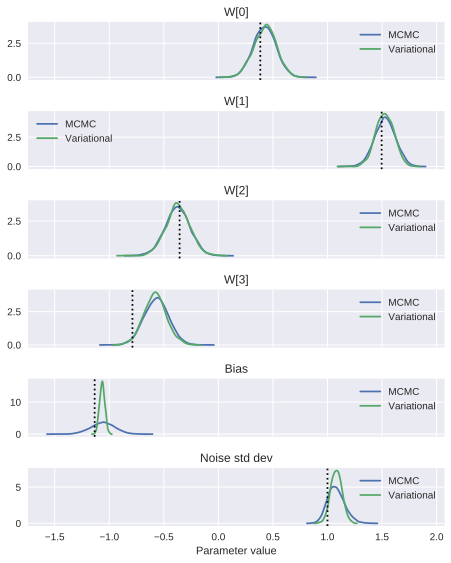

In [0]:
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 1, sharex='all')
fig.set_size_inches(6.4, 8)
for i in range(D):
  t_ax = axes[i]
  sns.kdeplot(coeffs_samples[:,i], #MCMC posterior
              ax=t_ax, label='MCMC') 
  sns.kdeplot(w_post[:,i,0], #variational posterior
              ax=t_ax, label='Variational') 
  t_ax.axvline(x=w_true[i], #true value
               color='k', linestyle=':') 
  t_ax.title.set_text('W[{}]'.format(i))
  
# Plot chains and distributions for bias
t_ax = axes[D]
sns.kdeplot(bias_samples[:,0], #MCMC posterior
            ax=t_ax, label='MCMC') 
sns.kdeplot(b_post[:,0], #variational posterior
            ax=t_ax, label='Variational') 
t_ax.axvline(x=b_true, #true value
             color='k', linestyle=':') 
t_ax.title.set_text('Bias')

# Plot chains and distributions for noise std dev
t_ax = axes[D+1]
sns.kdeplot(noise_std_samples[:,0], #MCMC posterior
            ax=t_ax, label='MCMC') 
sns.kdeplot(n_post[:,0], #variational estimate
            ax=t_ax, label='Variational') 
t_ax.axvline(x=noise_std_true, #true value
             color='k', linestyle=':') 
t_ax.title.set_text('Noise std dev')

axes[D+1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

The posteriors for the four weight parameters are very similar for both methods!  The bias posterior of the variational model is a lot sharper than the posterior for the same parameter using MCMC sampling.  I'm not entirely sure why that is - if anyone has any ideas please comment! 

Finally, the noise standard deviation parameter's posterior as computed by variational inference is similar to the posterior obtained via MCMC, but not exactly the same.  The distributions appear to have similar means and variances, but notice that the posterior computed with MCMC is slightly more positively skewed.  The variational posterior has a non-skewed normal distribution shape because, remember, we forced each parameter's posterior to be a normal distribution when we replaced each parameter with a normal distribution in order to do variational inference!

### Predictive Distributions 

Let's also compare the posterior predictive distributions on some individual validation datapoints.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

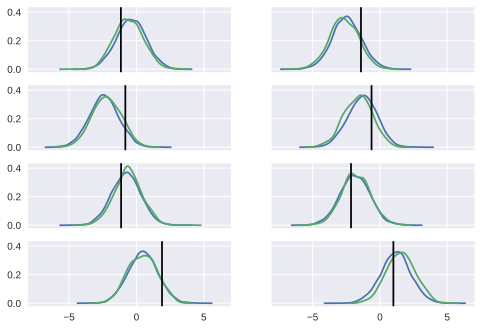

In [0]:
# Plot some datapoints and their prediction distributions
# as computed by MCMC and variational Bayes
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist_var = prediction_dist_var[:, ix, 0]
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, ax=axes[i][j])
    sns.kdeplot(pred_dist_var, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0], color='k')

Comparing the coverage of the 95% interval between the two inference methods, it looks like MCMC's uncertainty estimates are a bit too high, and the variational uncertainty estimates are a bit too low.

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
within_conf_int_var = np.zeros(N_val)
for i in range(N_val):
  # For MCMC
  pred_dist = prediction_distribution[i,:]  
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1
    
  # For variational model
  pred_dist_var = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist_var, q0)
  p1 = np.percentile(pred_dist_var, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int_var[i] = 1
    
# Print 95% interval coverage
print('Percent of validation samples w/i the %0.1f %% confidence interval:' 
      % (q1-q0))
print('MCMC: %0.1f%%' % (100*np.mean(within_conf_int)))
print('Variational: %0.1f%%' % (100*np.mean(within_conf_int_var)))

Percent of validation samples w/i the 95.0 % confidence interval:
MCMC: 97.4%
Variational: 93.7%


The MCMC confidence intervals are a little too large likely because it slightly overestimated the value of the noise standard deviation.  If you take a look at the MCMC posterior estimates, most of the posterior distribution's mass lies above the true value (and thus the posterior prediction overestimates the effect of noise, and thus overestimates uncertainty).  This isn't neccesarily because the MCMC method is *wrong*, but rather because the original 100 datapoints used to fit the model were more indicitacive of a larger noise standard deviation, due only to chance.  If you run the code several times with different seeds, the coverage of the 95% interval is sometimes greater than 95%, sometimes less, but is centered around 95%.

On the other hand, the variational coverage of the 95% interval is consistently low (running with different seeds almost always gives a coverage less than 95%).  This is probably because for the variational model, the estimated posterior distribution for the bias parameter was far too sharp.  Therefore the model is leaving out a source of uncertainty, and is over-sure as to its predicted values.

## Conclusion

TensorFlow Probability is a great new package for probabilistic model-building and inference, which supports both classical MCMC methods and stochastic variational inference.  With both these inference methods, we can estimate how uncertain we are about the model parameters (via the posterior distribution), and how uncertain we are about the predicted value of a new datapoint (via the posterior predictive distributions).  Variational inference is a lot faster than MCMC sampling, but it makes assumptions about the shape of the posterior distributions and about parameter independence.

It's also important to realize that TensorFlow Probability is, like I said, a very new project.  Unfortunately that means it's changing a lot and the documentation leaves a lot to be desired.  The API reference is great, but there aren't many simple examples which fully explain how the package is doing things, or why.  I wouldn't be suprised if a lot of things in the code above become outdated pretty quick!
